# Hyper Parameter Optimization For Random Forest

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'RandomForest'

In [2]:
current_path = os.getcwd()
current_path

'/output/workspace/Band-gap-predict/SingleModels/RandomForest'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [7]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")

# create an model
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),  # standardize the data
    ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))  # random forest model
])

# define the parameter grid for model(total 360 combinations)
param_distributions = {
    # general speaking, more n_estimators better performance, more overfitt, in order to speed up the optimization, we choose small n_estimators
    'rf__n_estimators': [100, 200],  # number of trees in the forest 
    'rf__max_depth': [None, 5, 7, 10],  # maximum depth of the tree, None means nodes are expanded until all leaves are pure
    'rf__min_samples_split': [2, 6, 10],  # minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4],    # minimum number of samples required to be at a leaf node
    'rf__max_features': ['sqrt', 'log2', 0.25, 0.5, 1]  # number of features to consider when looking for the best split, None means all features
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a GridSearchCV object (n_iter=5, runtime=30s)
random_search = RandomizedSearchCV(estimator=rf_pipe, param_distributions=param_distributions,
                n_iter=150, cv=kf, verbose=1, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

# fit the model to the training data
random_search.fit(dft_train_X, dft_train_y)

['DFT RandomForest'] HP optimazation begin...
Fitting 5 folds for each of 150 candidates, totalling 750 fits


/output/.pylibs/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 5, 7, 10],
                                        'rf__max_features': ['sqrt', 'log2',
                                                             0.25, 0.5, 1],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 6, 10],
                                        'rf__n_estimators': [100, 200]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_rf__n_estimators', 'param_rf__max_depth', 
                                 'param_rf__min_samples_split', 'param_rf__min_samples_leaf', 'param_rf__max_features', 'train_rmse', 'test_rmse']]
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'dft_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': None}
Best Cross-Validation RMSE: 0.7231


,rank_test_score,param_rf__n_estimators,param_rf__max_depth,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,train_rmse,test_rmse
46,1,200,None,2,1,0.5,0.315765,0.723068
7,2,200,None,6,1,0.5,0.359407,0.723667
35,3,200,None,6,1,0.25,0.367131,0.723933
122,4,100,None,2,1,0.25,0.318061,0.724637
4,5,100,None,6,1,0.5,0.361591,0.725551


### Overfitting check

####################################################################################################
[DFT - RandomForest] Training RandomForest on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  18.9s
Model training completed!
[Train_error] Evaluating DFT RandomForest on DFT train set:


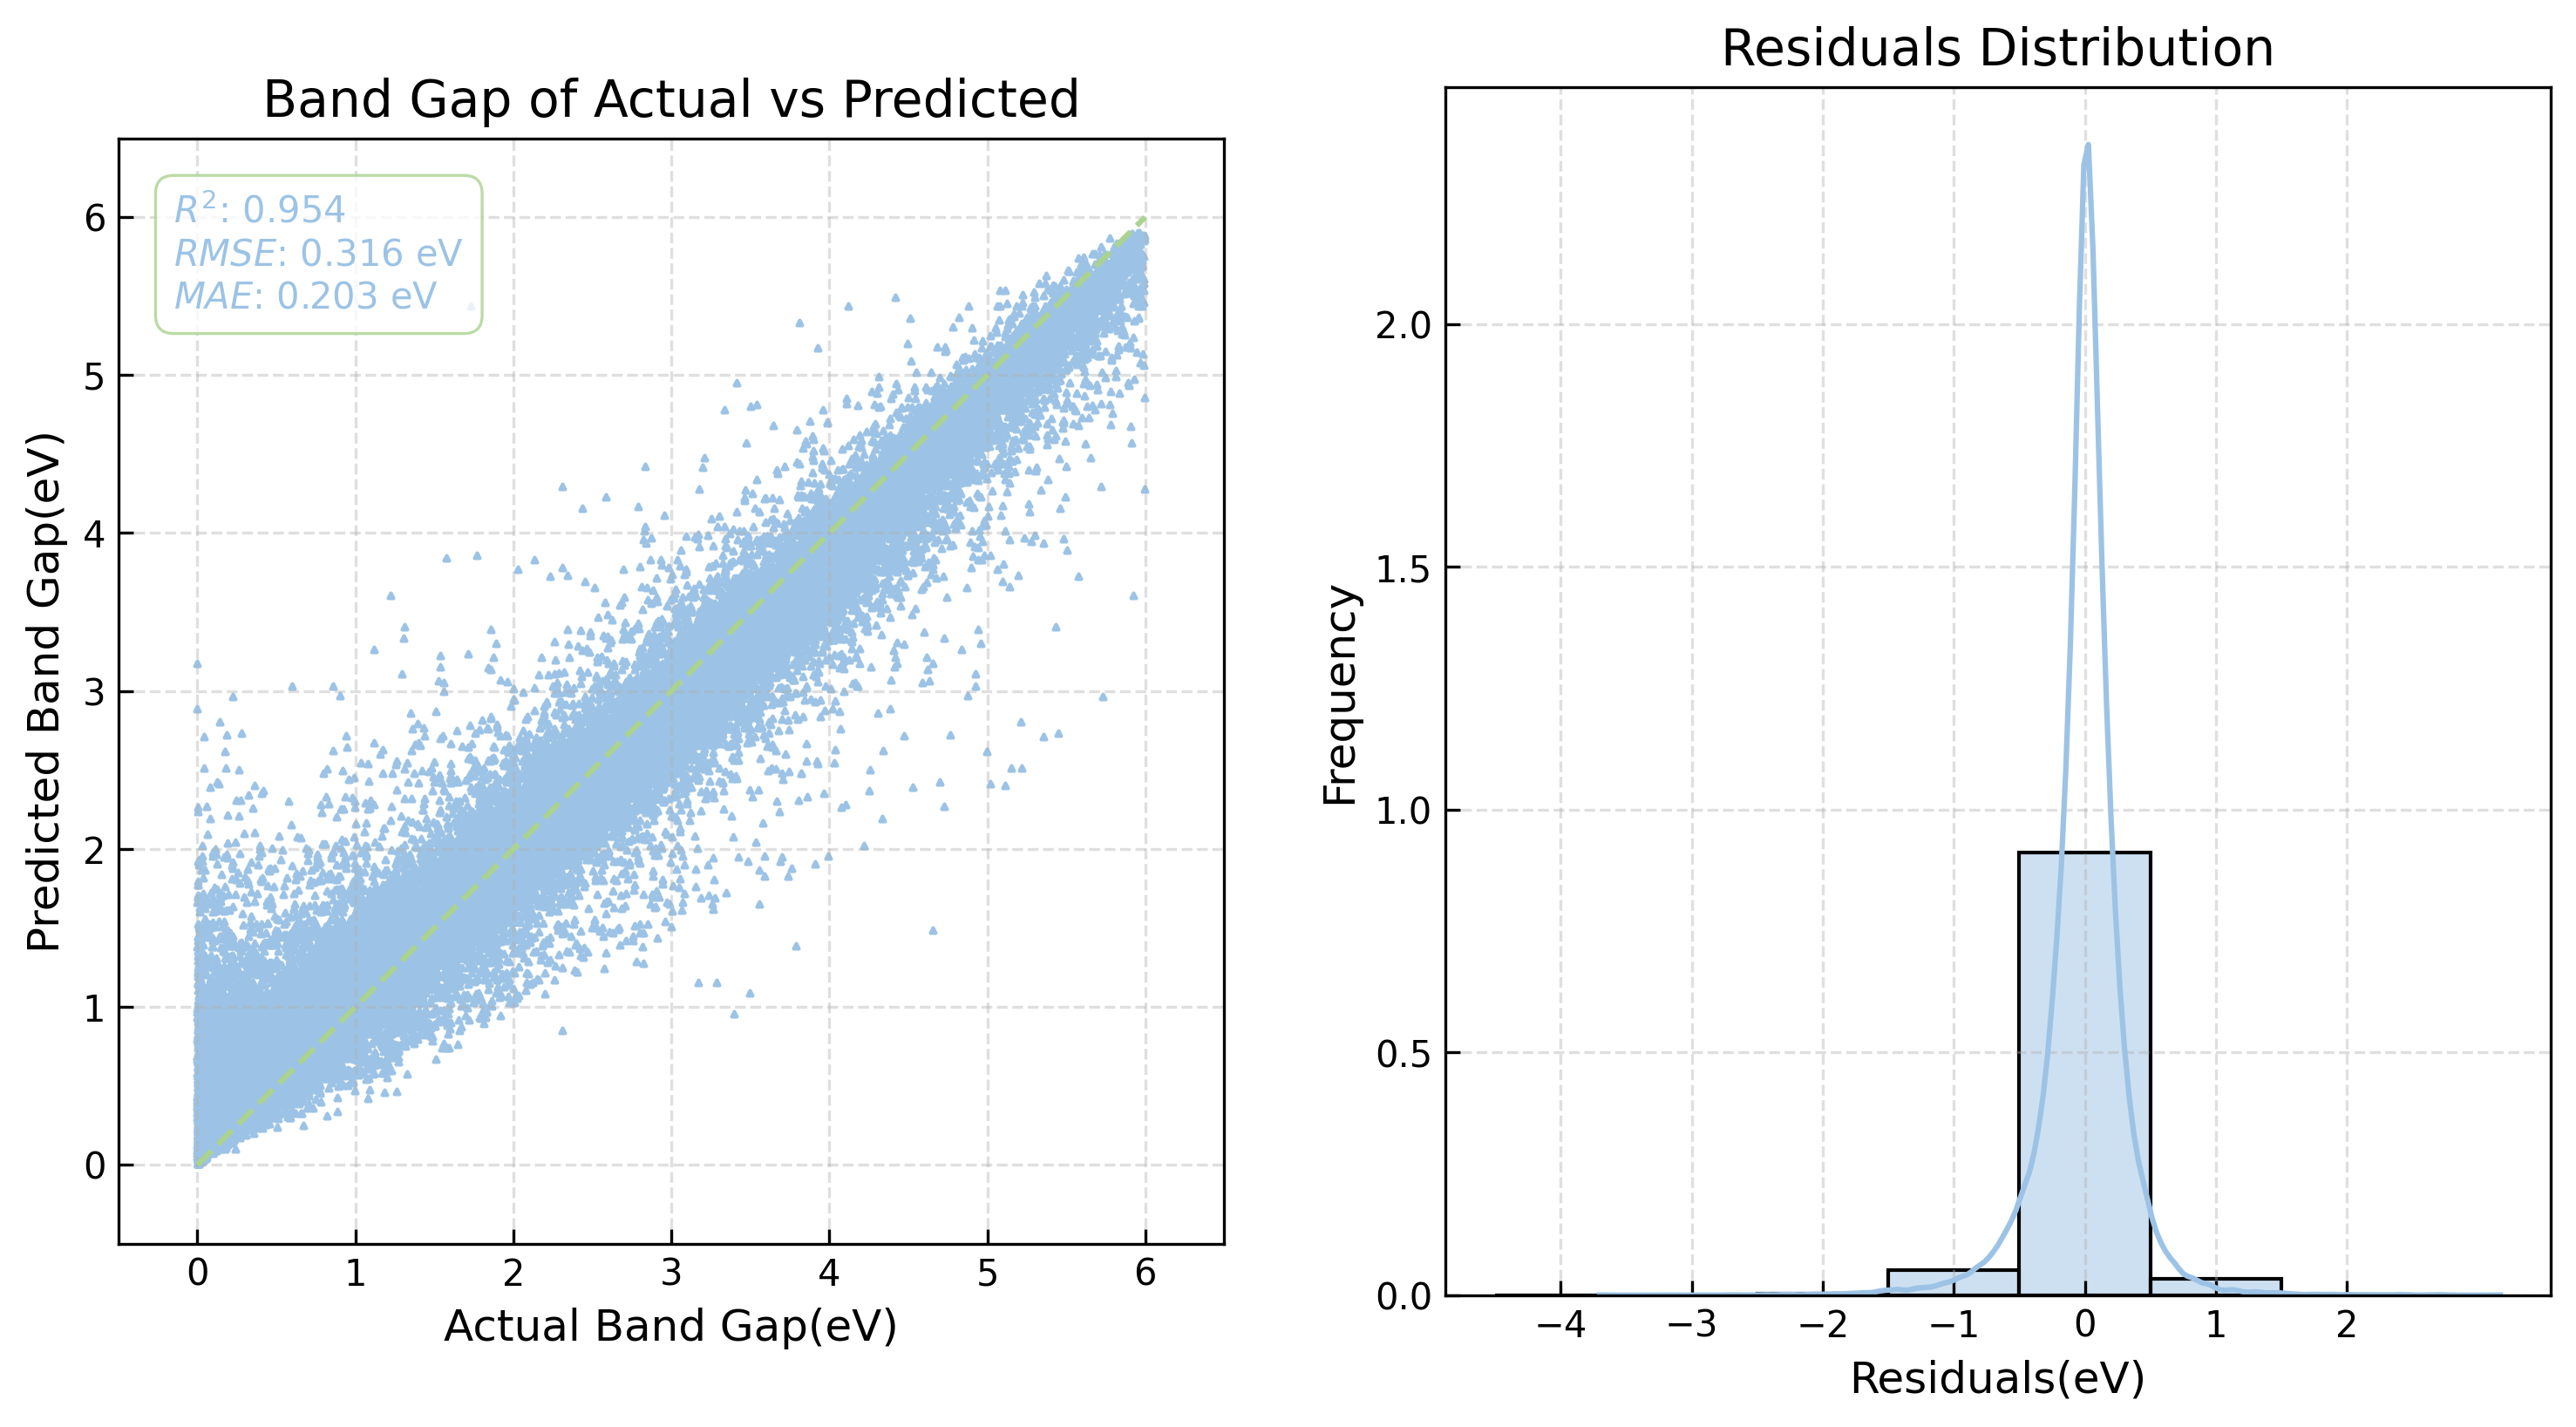


Model Evaluation Results:
Test set: R²: 0.9542 RMSE: 0.3161 MAE: 0.2026
[Test DFT -> DFT] Evaluating DFT RandomForest on DFT test set:


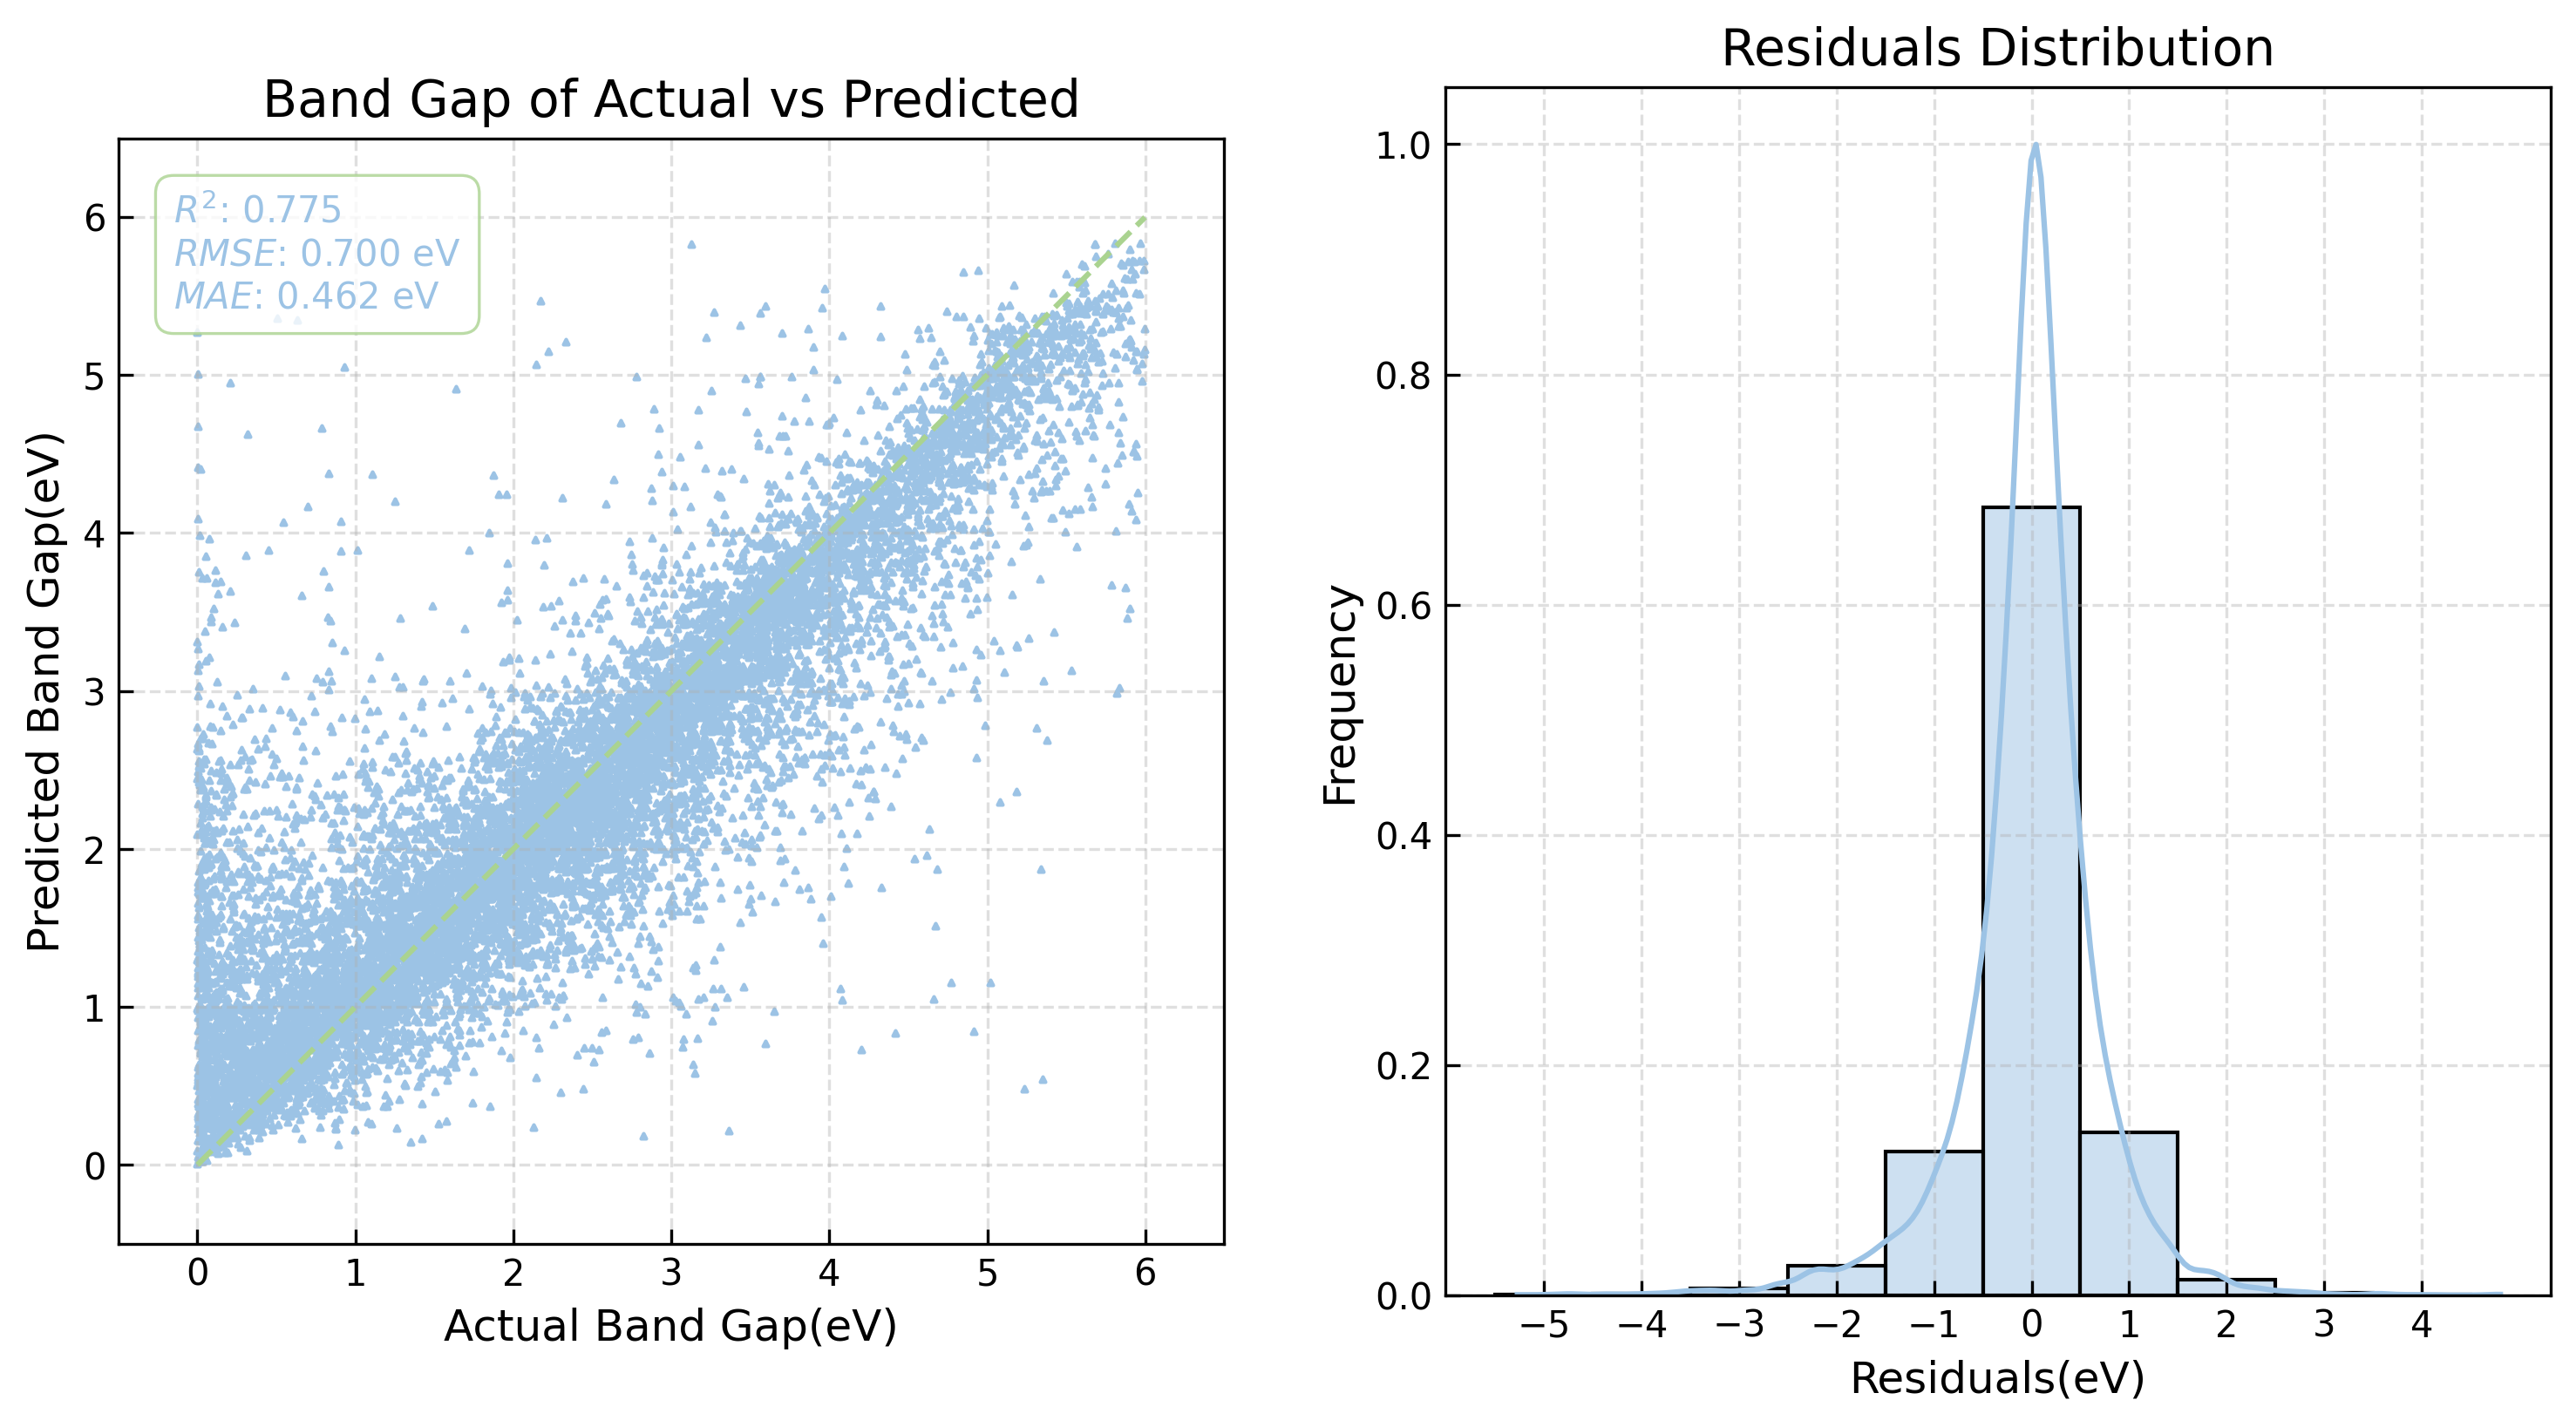


Model Evaluation Results:
Test set: R²: 0.7755 RMSE: 0.7004 MAE: 0.4619
[Test DFT -> EXP] Evaluating DFT RandomForest on EXP test set:


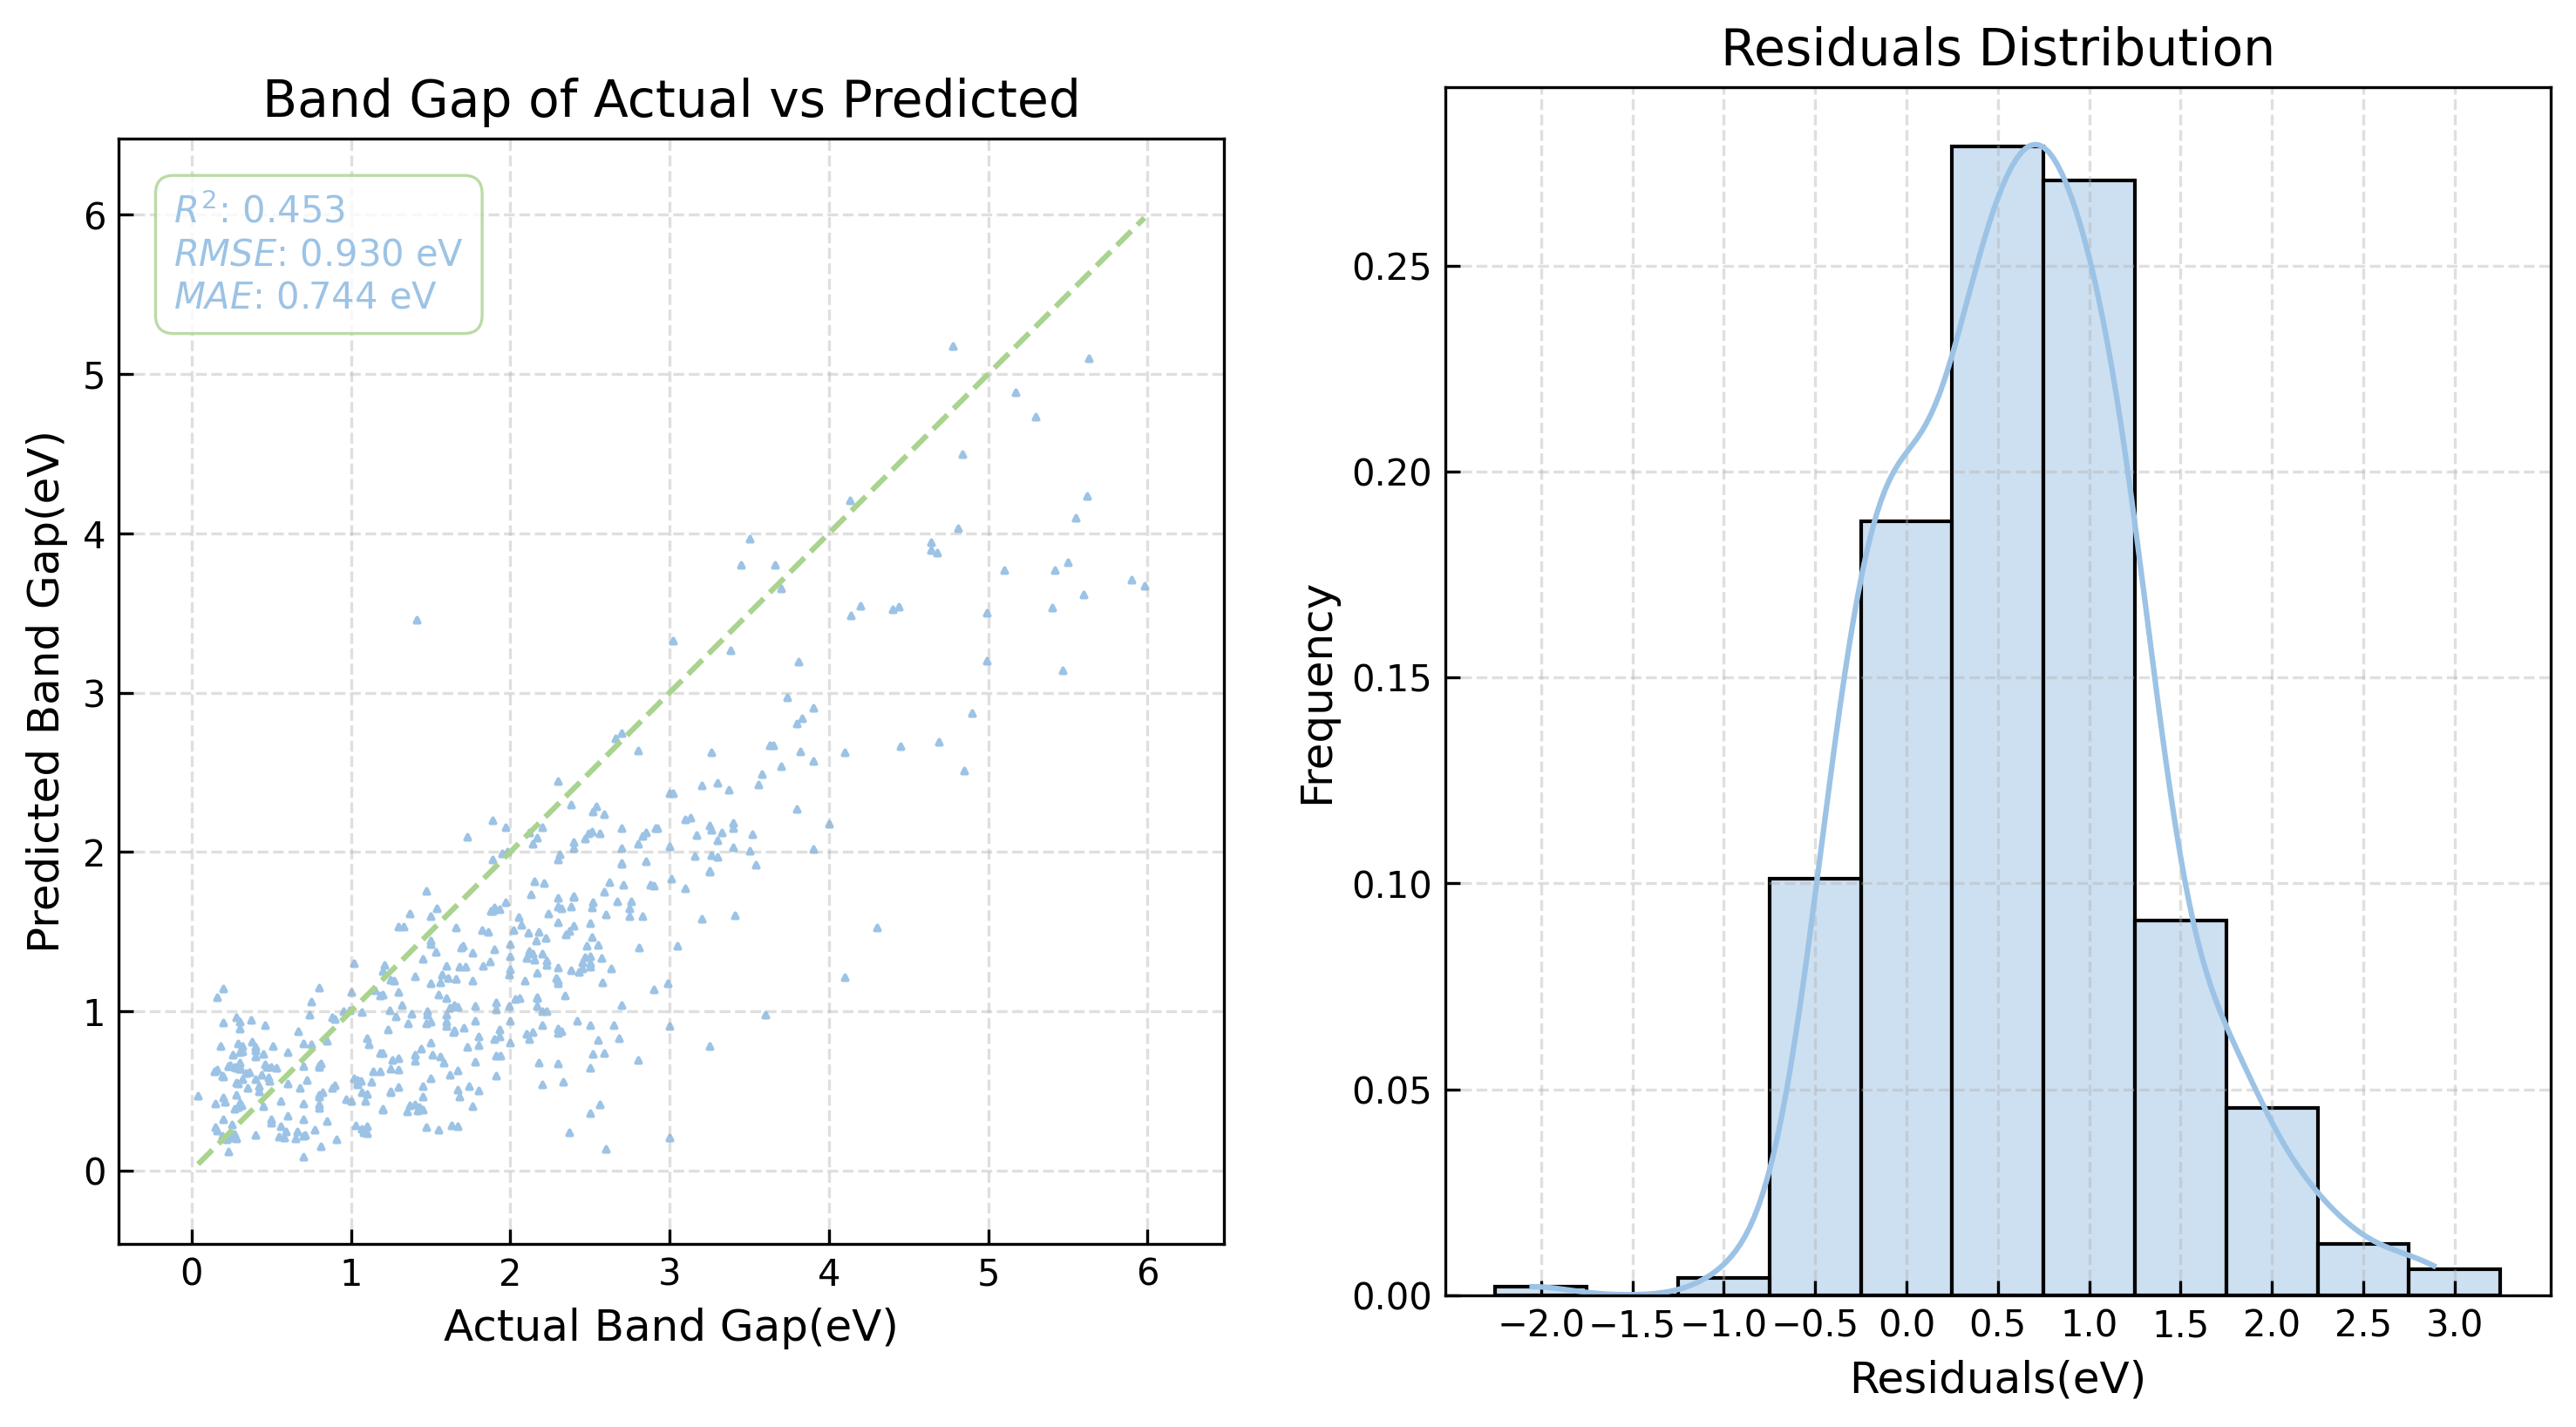


Model Evaluation Results:
Test set: R²: 0.4528 RMSE: 0.9296 MAE: 0.7436


In [15]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
random_forest_best = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(random_forest_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [16]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,RandomForest,Train,dft,dft,0.954184,0.316072,0.202619
1,RandomForest,Test,dft,dft,0.775490,0.700375,0.461903
2,RandomForest,Test,dft,exp,0.452786,0.929616,0.743605


### EXP Model

In [6]:
# using grid search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimazation begin...")
# create an model
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),  # standardize the data
    ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))  # random forest model
])
# define the parameter grid for model(total 480 combinations)
param_distributions = {
    'rf__n_estimators': [300, 500],  # number of trees in the forest
    'rf__max_depth': [None, 5, 7, 10],  # maximum depth of the tree, None means nodes are expanded until all leaves are pure
    'rf__min_samples_split': [2, 4, 6],  # minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 3, 4],    # minimum number of samples required to be at a leaf node
    'rf__max_features': ['sqrt', 'log2', 0.25, 0.5, 1]  # number of features to consider when looking for the best split, None means all features
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_distributions,
                cv=kf, verbose=1, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)

['EXP RandomForest'] HP optimazation begin...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 7, 10],
                         'rf__max_features': ['sqrt', 'log2', 0.25, 0.5, 1],
                         'rf__min_samples_leaf': [1, 2, 3, 4],
                         'rf__min_samples_split': [2, 4, 6],
                         'rf__n_estimators': [300, 500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [7]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_rf__n_estimators', 'param_rf__max_depth', 
                                 'param_rf__min_samples_split', 'param_rf__min_samples_leaf', 'param_rf__max_features', 'train_rmse', 'test_rmse']]
# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'exp_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Best Cross-Validation RMSE: 0.5960


,rank_test_score,param_rf__n_estimators,param_rf__max_depth,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,train_rmse,test_rmse
1,1,500,None,2,1,sqrt,0.219027,0.595976
0,2,300,None,2,1,sqrt,0.219418,0.596736
73,3,500,None,2,1,0.5,0.219010,0.596828
72,4,300,None,2,1,0.5,0.219183,0.597731
49,5,500,None,2,1,0.25,0.218376,0.597879


### Overfitting check

####################################################################################################
[EXP - RandomForest] Training RandomForest on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s
Model training completed!
[Train_error] Evaluating EXP RandomForest on EXP train set:


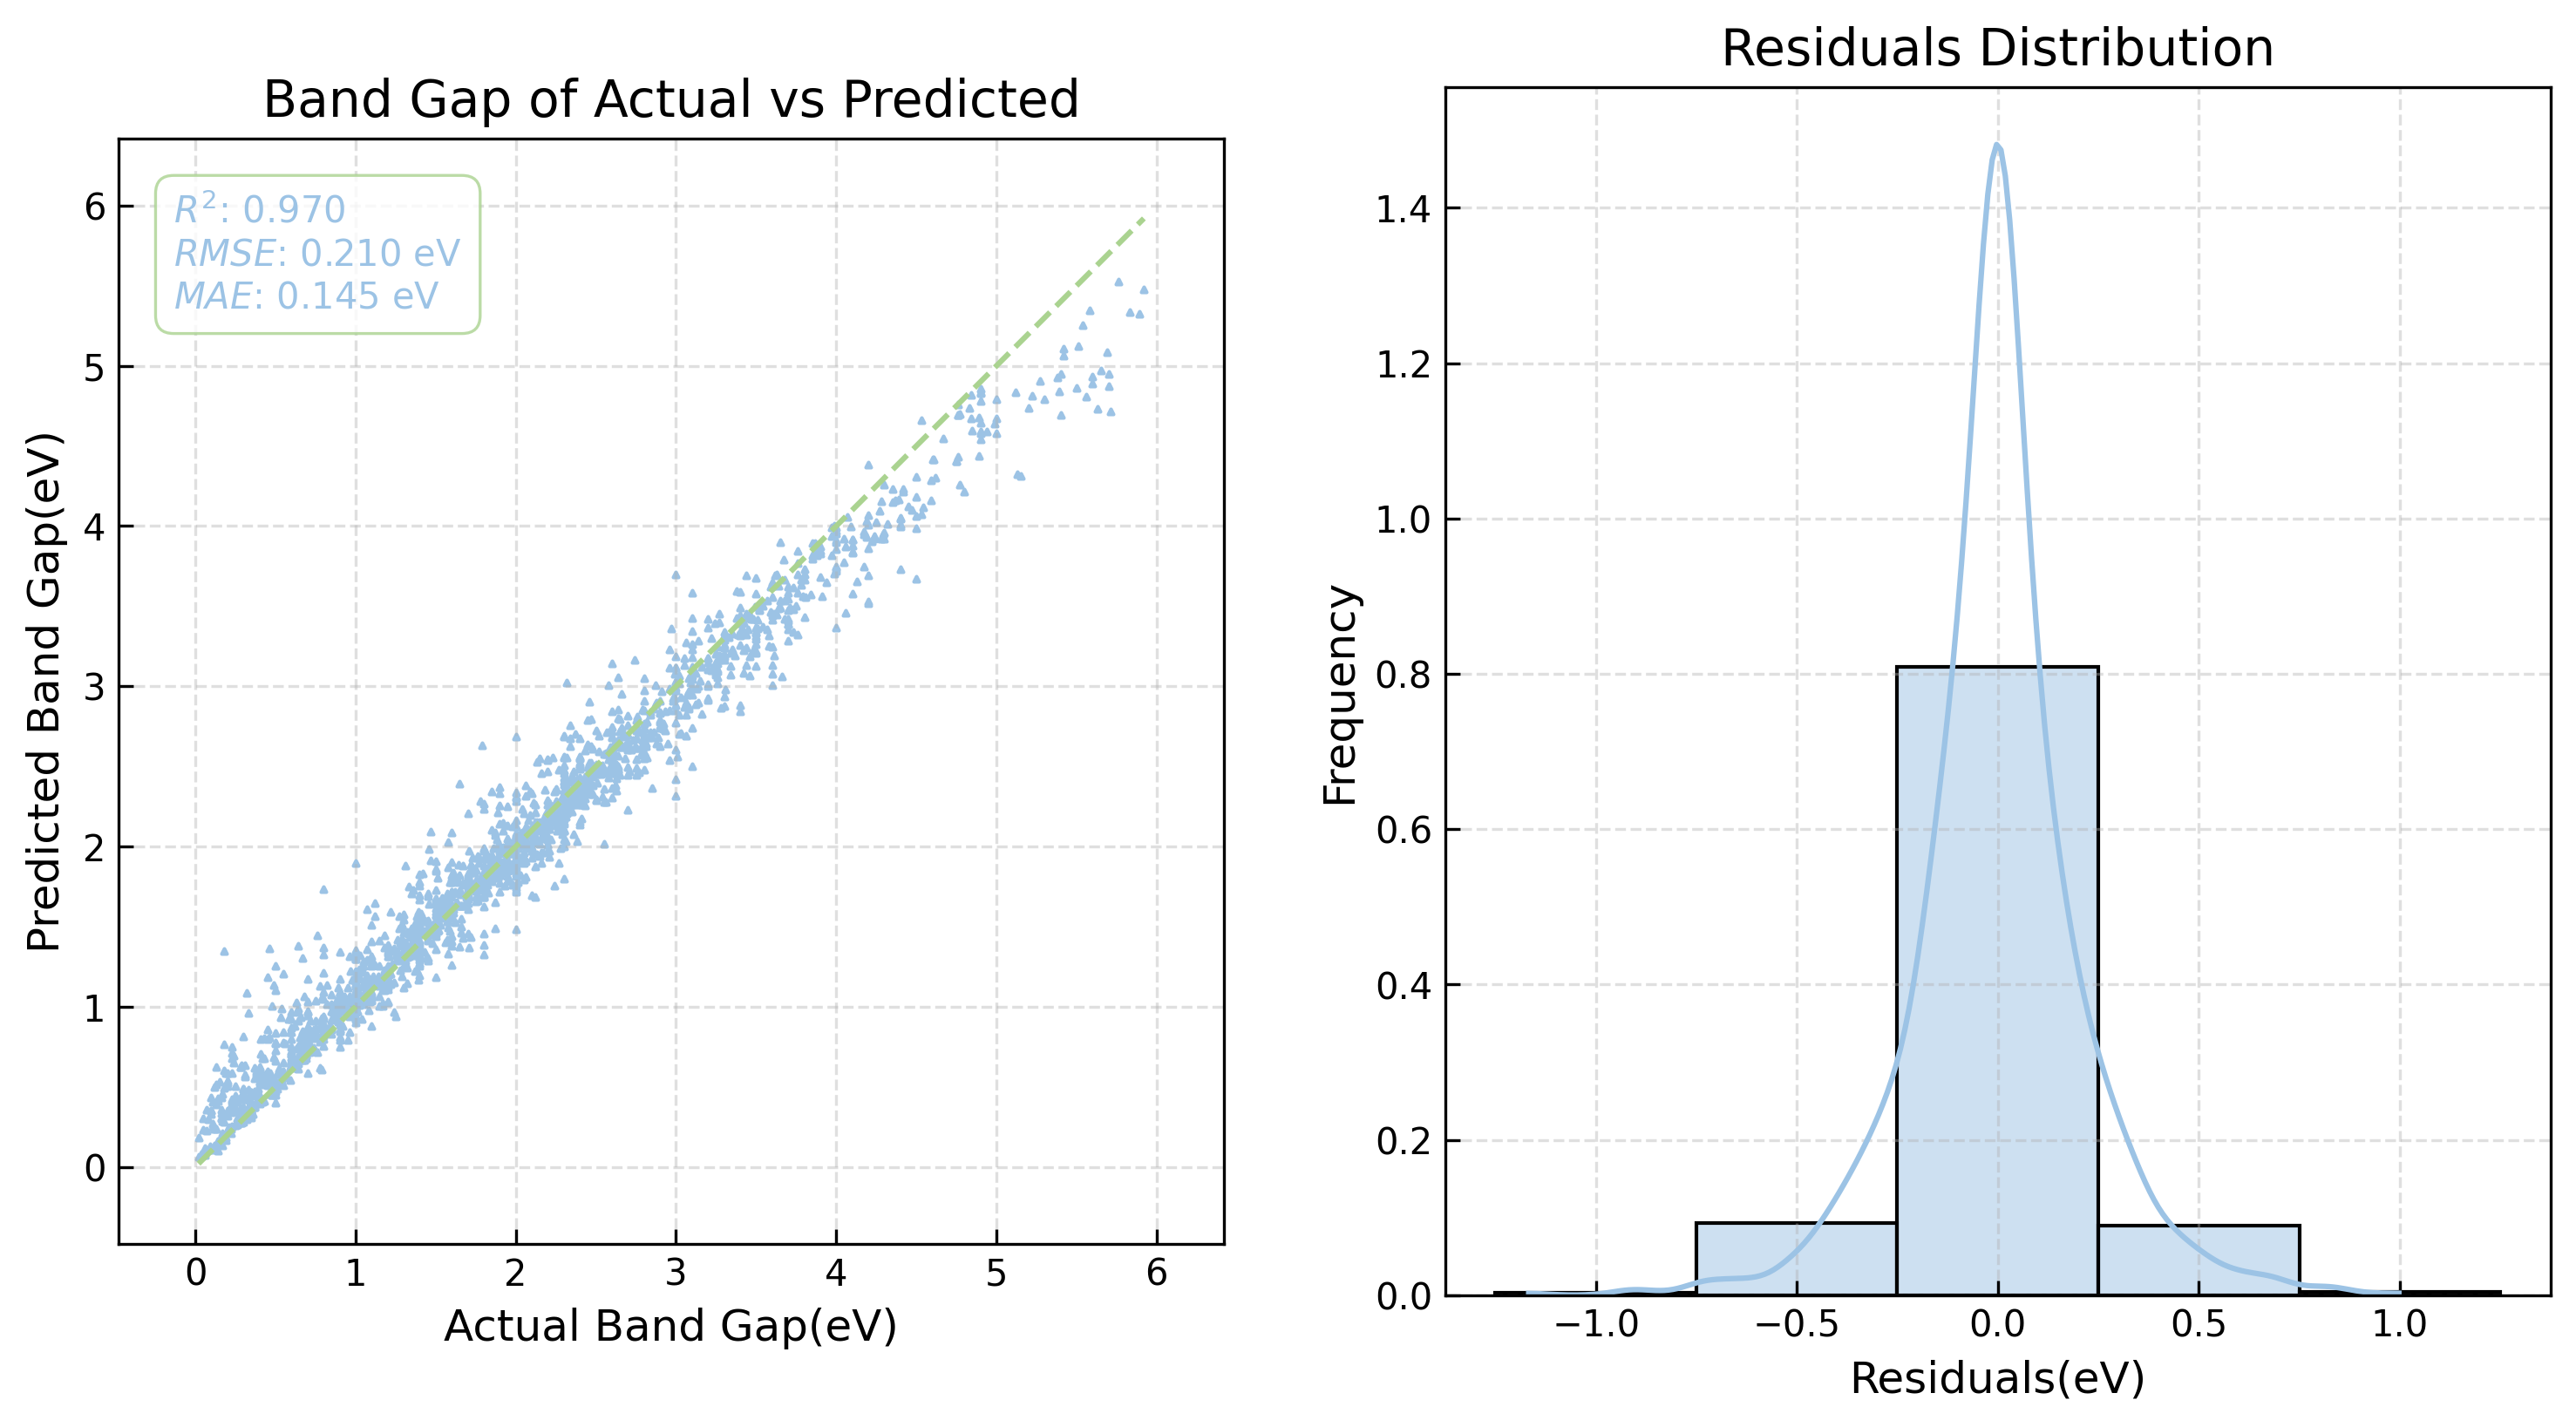


Model Evaluation Results:
Test set: R²: 0.9701 RMSE: 0.2099 MAE: 0.1447
[Test EXP -> EXP] Evaluating EXP RandomForest on EXP test set:


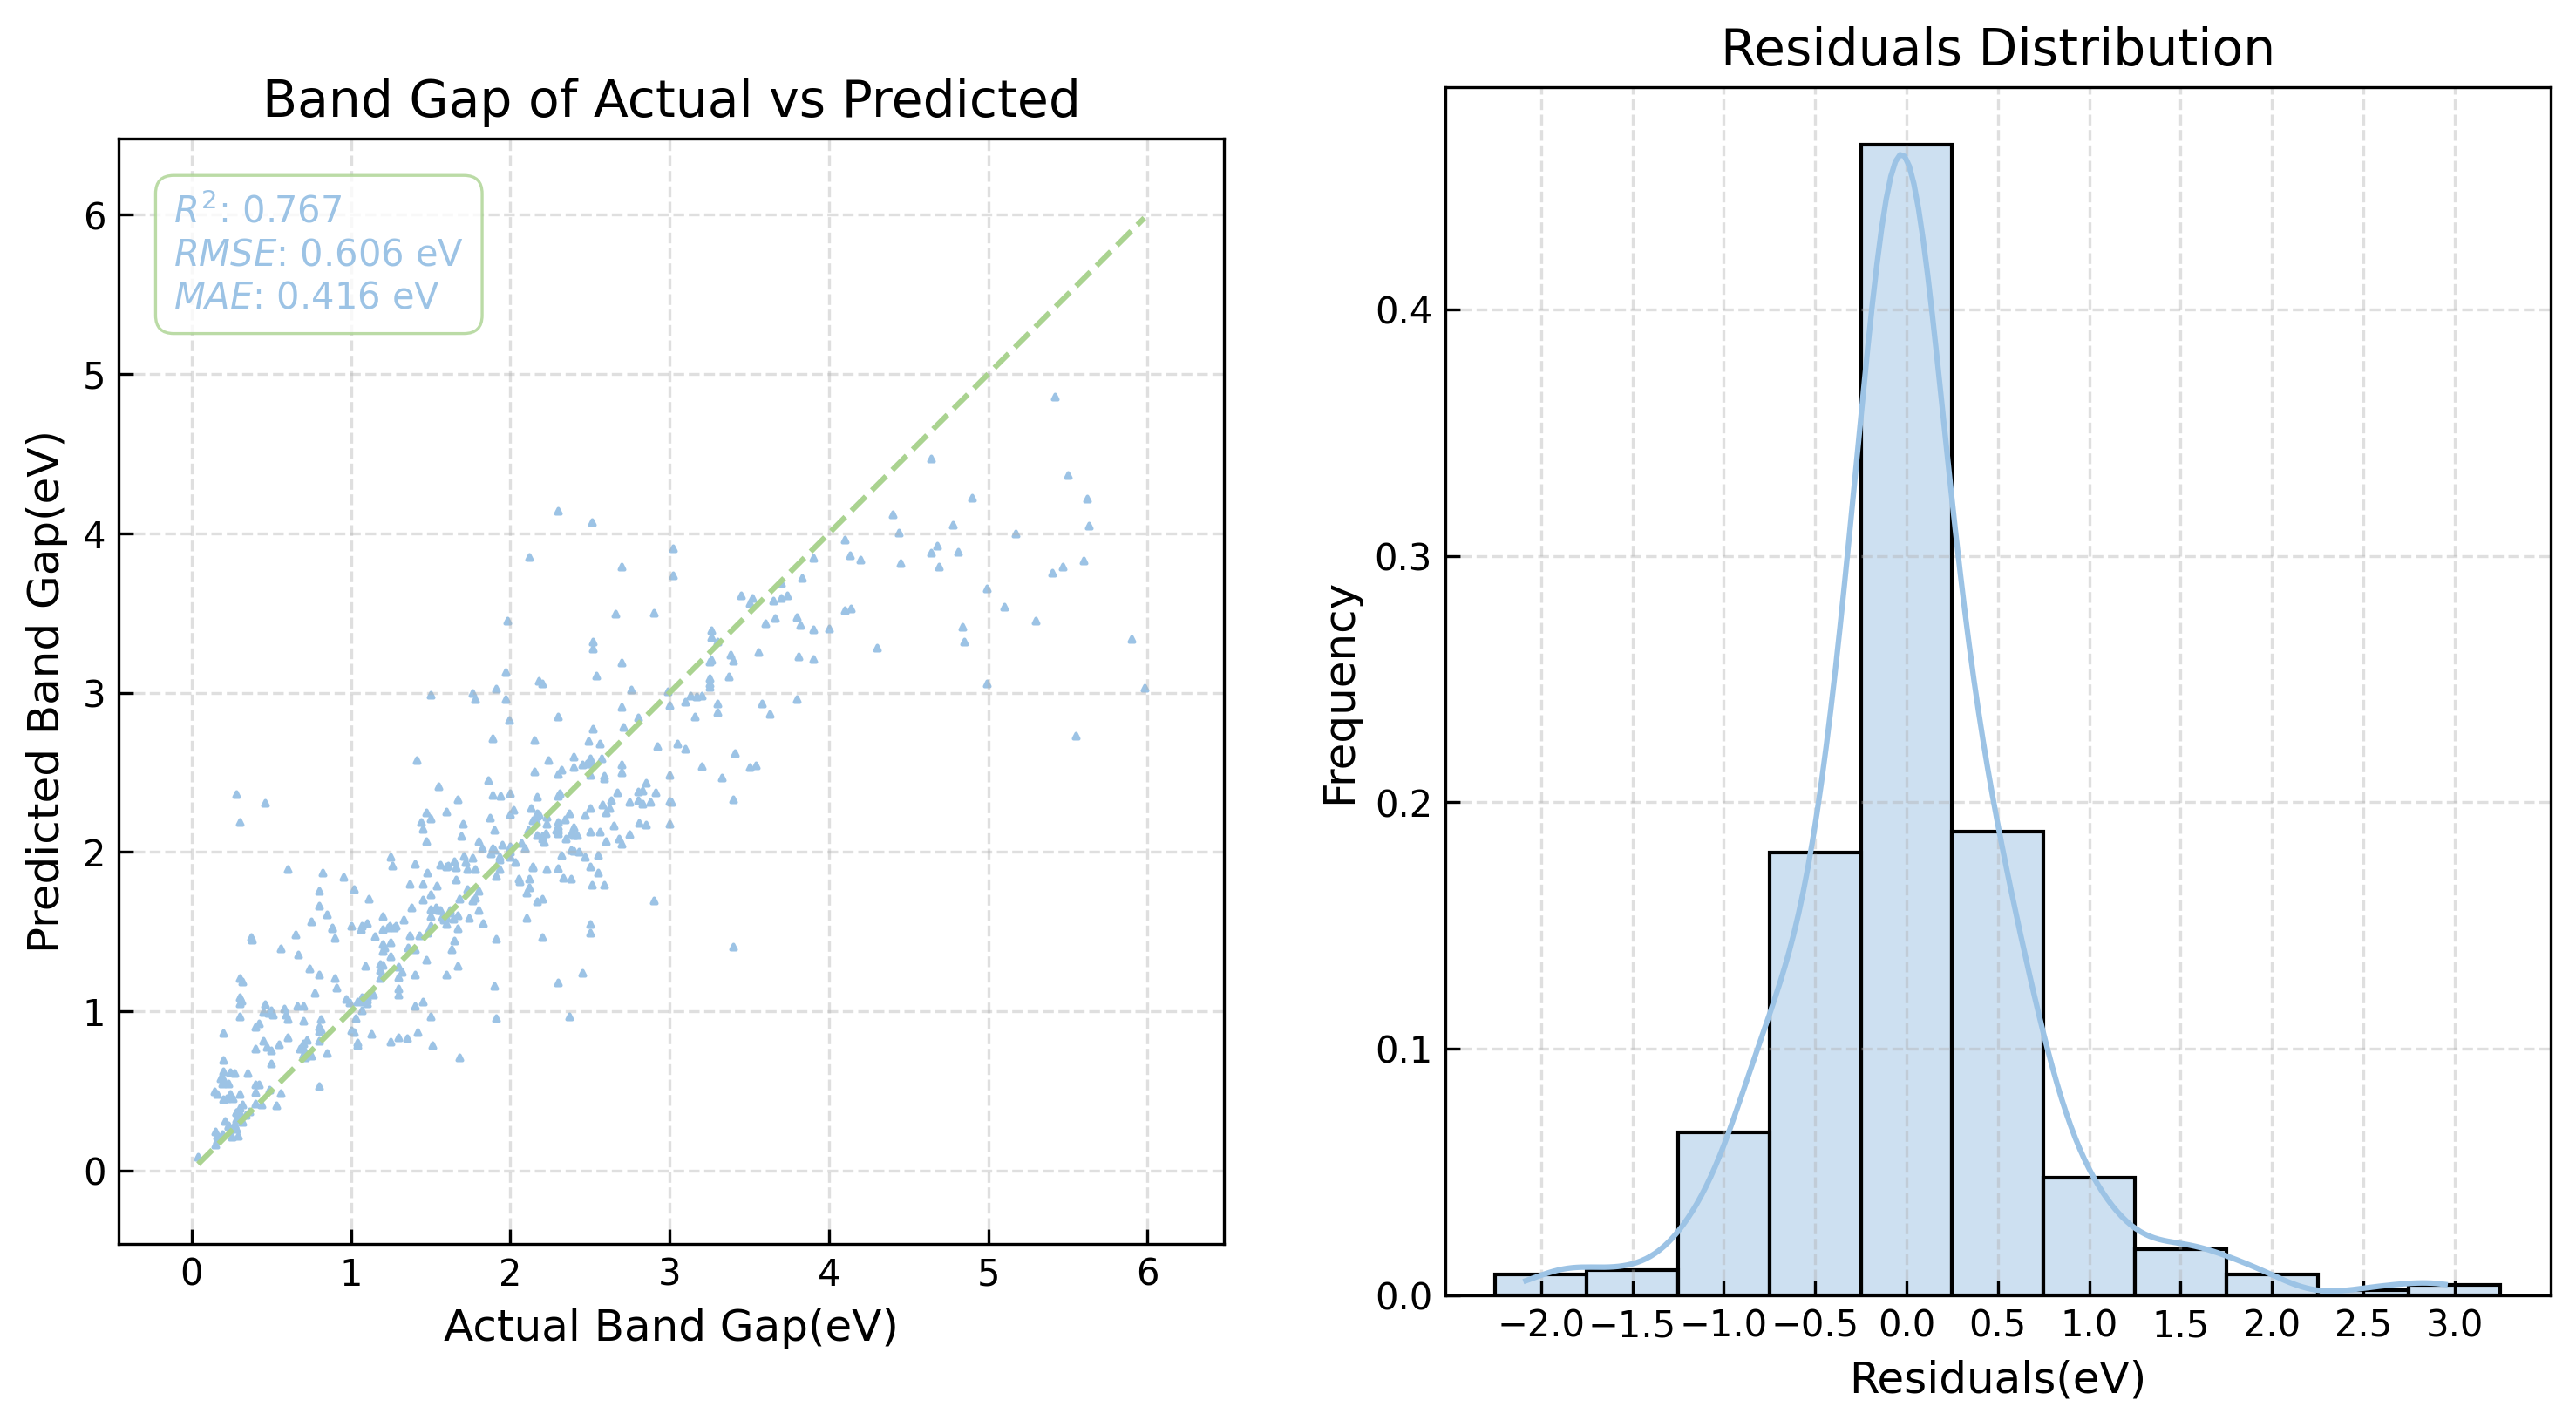


Model Evaluation Results:
Test set: R²: 0.7671 RMSE: 0.6064 MAE: 0.4161
[Test EXP -> DFT] Evaluating EXP RandomForest on DFT test set:


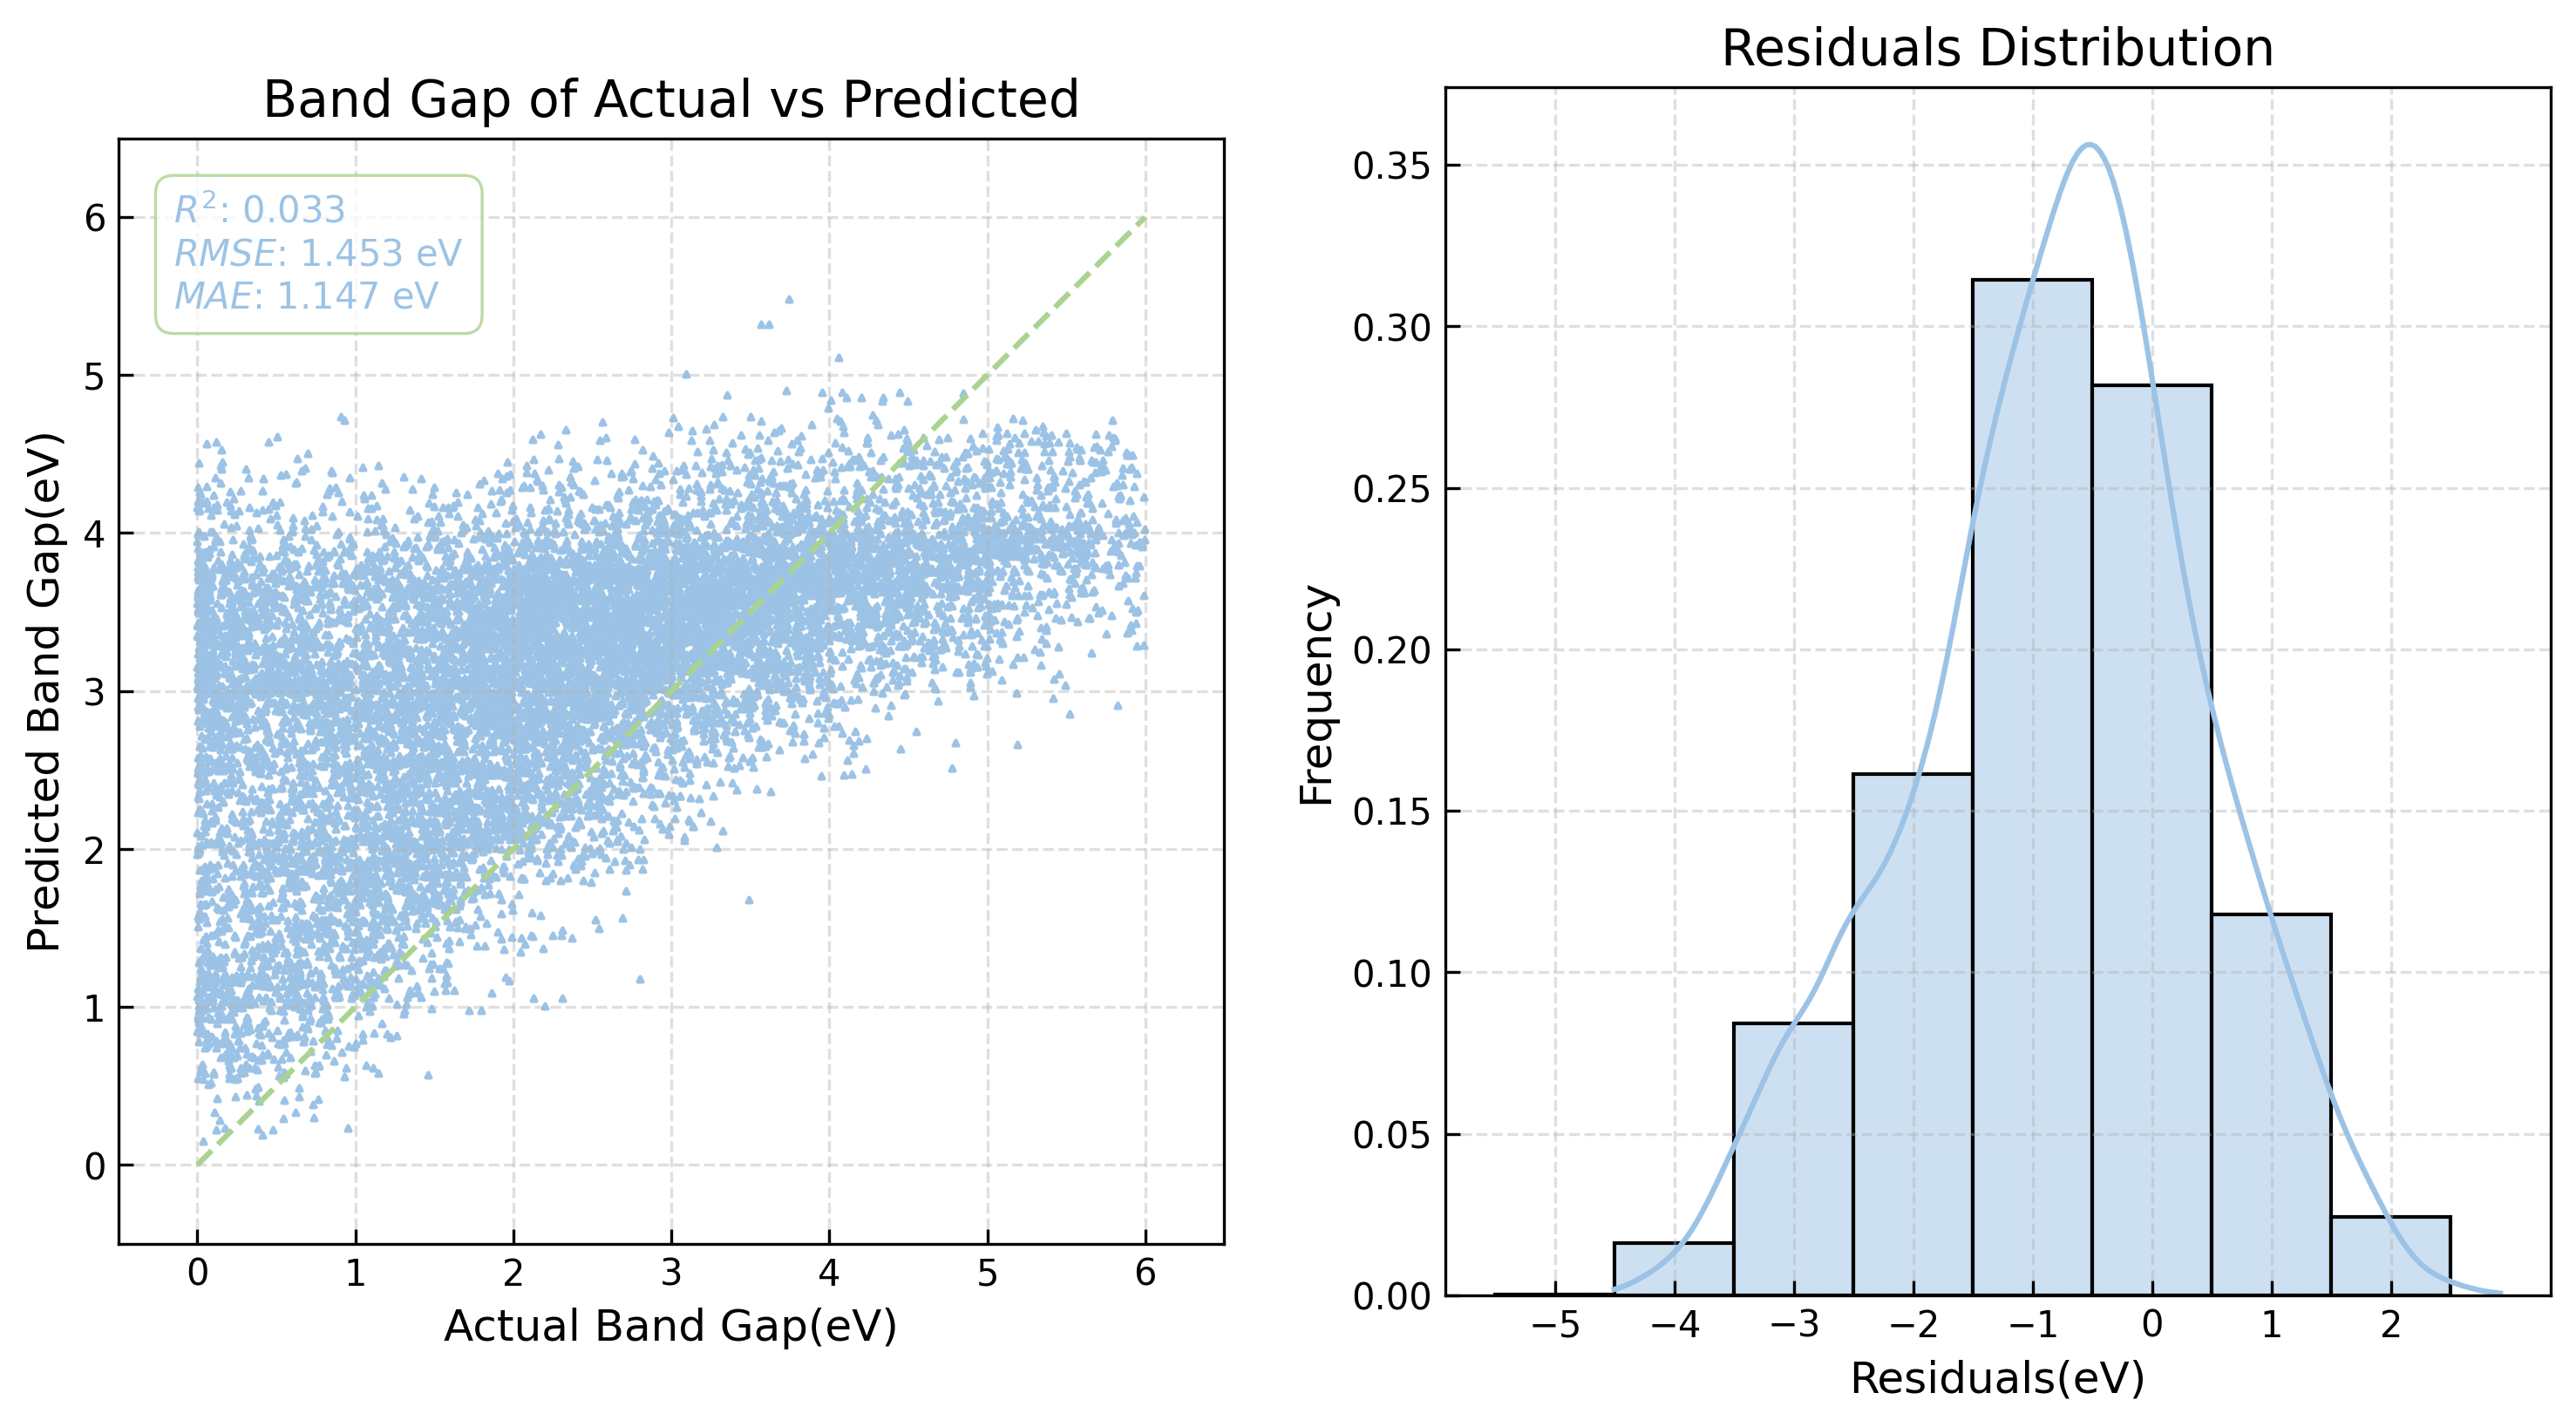


Model Evaluation Results:
Test set: R²: 0.0331 RMSE: 1.4535 MAE: 1.1467


In [8]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
random_forest_best = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=RANDOM_SEED,
    n_jobs=-1
)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(random_forest_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [9]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,RandomForest,Train,exp,exp,0.970067,0.209920,0.144719
1,RandomForest,Test,exp,exp,0.767142,0.606415,0.416143
2,RandomForest,Test,exp,dft,0.033056,1.453494,1.146716
